In [1]:
import Dates
println("Last updated: ", Dates.now(), " (PT)")

Last updated: 2020-07-01T16:40:31.665 (PT)


In [2]:
# Load environment
import Pkg; Pkg.activate("../../../")

 Activating environment at `~/repo/TuringBnpBenchmarks/Project.toml`


In [3]:
# Import Libraries
using Turing
import Turing.RandomMeasures.DirichletProcess
import Turing.RandomMeasures.ChineseRestaurantProcess
using Distributions
using PyPlot
import Random
using BenchmarkTools
import StatsBase.countmap

In [4]:
# rand(ChineseRestaurantProcess(DirichletProcess(1.0), [155, 10]))

In [5]:
function extract(chain, sym; burn=0)
    tail  = chain[sym].value.data[(burn + 1):end, :, :]
    return dropdims(tail, dims=3)
end

extract (generic function with 1 method)

In [6]:
function counts_plot(x; density=false, color="C0", lw=4)
    cm_x = countmap(x)
    number = collect(keys(cm_x))
    count = let
        c = collect(values(cm_x))
        density ? c / sum(c) : c
    end
    plt.vlines(number, 0, count, color=color, lw=lw)
end

counts_plot (generic function with 1 method)

In [14]:
# FIXME: Not working???

# Define model
@model infiniteGMM(x) = begin
    nobs = length(x)
    
    # Hyper-parameters, i.e. concentration parameter and parameters of H.
    alpha = 1.0
    mu0 = 0.0
    sig0 = 1.0
    
    # Define random measure, e.g. Dirichlet process.
    rpm = DirichletProcess(alpha)
    
    # Define the base distribution, i.e. expected value of the Dirichlet process.
    H = Normal(mu0, sig0)
    
    # Latent assignment.
    z = tzeros(Int, nobs)
        
    # Locations of the infinitely many clusters.
    mu = tzeros(Float64, 0)
    
    for i in 1:nobs
        # Number of clusters.
        K = maximum(z)
        nk = Vector{Int}(map(k -> sum(z .== k), 1:K))

        # Draw the latent assignment.
        z[i] ~ ChineseRestaurantProcess(rpm, nk)
        
        # Create a new cluster?
        if z[i] > K
            push!(mu, 0.0)

            # Draw location of new cluster.
            mu[z[i]] ~ H
        end
                
        # Draw observation.
        x[i] ~ Normal(mu[z[i]], 1.0)
    end
end

# Generate data
Random.seed!(1)
data = vcat(randn(10), randn(10) .- 5, randn(10) .+ 10)
data .-= mean(data)
data /= std(data);

# Fit model
Random.seed!(2)
iterations = 1000
model_fun = infiniteGMM(data)
chain = sample(model_fun, SMC(), iterations);

In [15]:
samples = chain.value.data[:, 4:end, 1]
z = samples[:, end-30+1:end]
mu = samples[:, 1:end-30];

In [16]:
mu

1000×8 Array{Union{Missing, Float64},2}:
  0.159213  -1.08758     missing    missing  …  missing  missing  0.000128756
  0.159213  -1.08758     missing    missing     missing  missing  0.000892144
 -0.467335  -0.694251    missing    missing     missing  missing  0.000250955
 -0.467335  -0.694251  -0.128821    missing     missing  missing  0.0014401
 -0.467335  -0.694251  -0.128821    missing     missing  missing  0.000126863
 -0.467335  -0.694251  -0.128821    missing  …  missing  missing  0.000574869
 -0.225729   0.793905    missing    missing     missing  missing  0.000298816
 -0.225729   0.793905    missing    missing     missing  missing  0.000414291
 -0.225729   0.793905  -0.513999    missing     missing  missing  0.00010465
 -0.225729   0.793905    missing    missing     missing  missing  0.000172128
 -0.225729   0.793905    missing    missing  …  missing  missing  0.000172128
 -0.225729   0.793905    missing    missing     missing  missing  8.86499e-5
 -0.225729    missing    mi

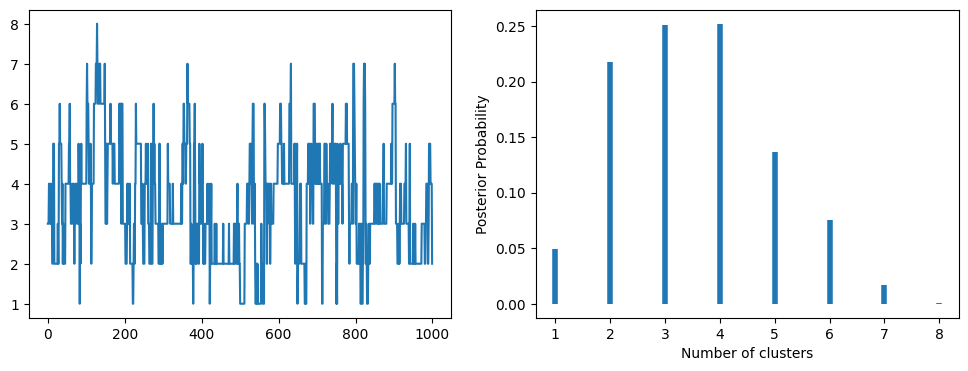

In [17]:
nclus = [length(unique(z[i, :])) for i in 1:size(z, 1)]
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(nclus);
plt.subplot(1, 2, 2);
counts_plot(nclus, density=true);
plt.xlabel("Number of clusters")
plt.ylabel("Posterior Probability");

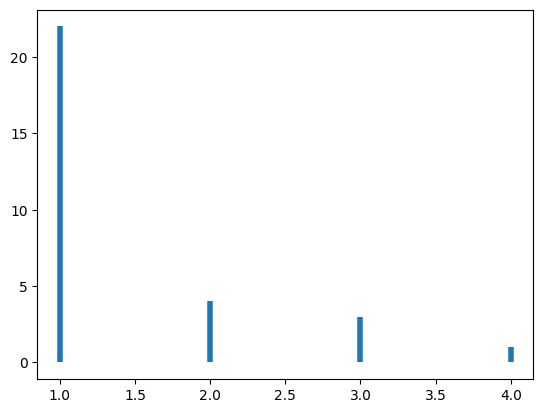

PyObject <matplotlib.collections.LineCollection object at 0x7f657abf3b38>

In [21]:
# counts_plot(z[end-2, :])

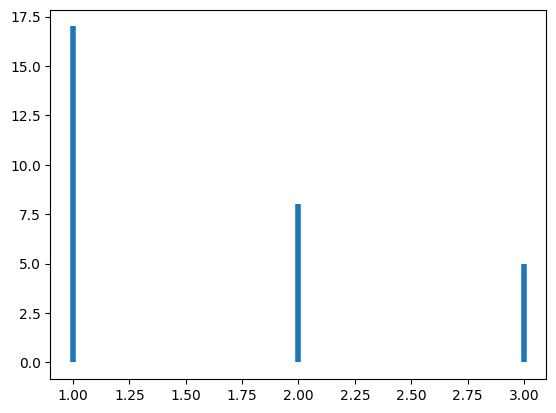

PyObject <matplotlib.collections.LineCollection object at 0x7f657ab5a4e0>

In [22]:
counts_plot(z[1,:])

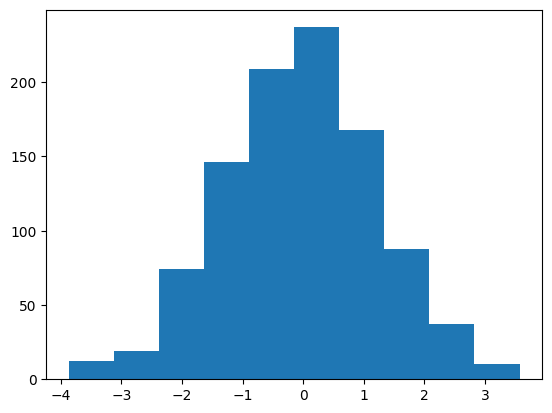

([12.0, 19.0, 74.0, 146.0, 209.0, 237.0, 168.0, 88.0, 37.0, 10.0], [-3.871491406541434, -3.1270847153756094, -2.3826780242097843, -1.638271333043959, -0.8938646418781344, -0.14945795071230972, 0.5949487404535159, 1.3393554316193406, 2.0837621227851653, 2.82816881395099, 3.5725755051168147], PyCall.PyObject[PyObject <matplotlib.patches.Rectangle object at 0x7f657a67d128>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a6efeb8>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a67d6d8>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a67da20>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a67dd68>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a6860f0>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a686438>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a686780>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a686ac8>, PyObject <matplotlib.patches.Rectangle object at 0x7f657a686e10>])

In [79]:
function rand_mu(mu, z, i)
    mu_vec =  filter(x -> !ismissing(x), mu[i, :])
    z = Int(rand(z[i, :]))
    mu_vec[z]
end
post_pred = [rand(Normal(rand_mu(mu, z, i), 1)) for i in 1:size(z, 1)]
plt.hist(post_pred)

In [66]:
mu

1000×8 Array{Union{Missing, Float64},2}:
  0.159213  -1.08758     missing    missing  …  missing  missing  0.000128756
  0.159213  -1.08758     missing    missing     missing  missing  0.000892144
 -0.467335  -0.694251    missing    missing     missing  missing  0.000250955
 -0.467335  -0.694251  -0.128821    missing     missing  missing  0.0014401
 -0.467335  -0.694251  -0.128821    missing     missing  missing  0.000126863
 -0.467335  -0.694251  -0.128821    missing  …  missing  missing  0.000574869
 -0.225729   0.793905    missing    missing     missing  missing  0.000298816
 -0.225729   0.793905    missing    missing     missing  missing  0.000414291
 -0.225729   0.793905  -0.513999    missing     missing  missing  0.00010465
 -0.225729   0.793905    missing    missing     missing  missing  0.000172128
 -0.225729   0.793905    missing    missing  …  missing  missing  0.000172128
 -0.225729   0.793905    missing    missing     missing  missing  8.86499e-5
 -0.225729    missing    mi

3-element Array{Union{Missing, Float64},1}:
  0.15921254145809435
 -1.087581216898693
  0.00012875582114905572